# Machine Learing, Gaussian Mixture Models
## The Expectation-Maximization algorithm for Gaussian mixture models

A **Gaussian Mixture Model** (GMM) is a probabilstic model that assumes the data points come from a mixture of several Gaussian (normal) distributions with unknown parameters. Each Gaussian distribution in this model is called a **component**, which has its own mean vector $\mu_k$, covariance matrix $\Sigma_k$, and mixture **weight** $\pi_k$. Specifically, the probabilty function of a GMM with $K$ components is:
<br>$p(x)=\sum_{k=0}^{K-1}\pi_k N(x|\mu_k,\Sigma_k)$
<br>where $\pi_k \ge 0$ and $\sum_{k=0}^{K-1}\pi_k =1$. Also, $N(x|\mu_k,\Sigma_k)$ is the value of probability function of a Gaussian distribution with mean vector $\mu_k$ and covariance matrix $\Sigma_k$ at data point $x$.

---
The algorithm to estimate the unknown parameters of a GMM is called the **Expectation-Maximization** algorithm or the **EM algorithm** for short. The EM algorithm is an iterative emthod which alternates between two steps until convergence: The Expectation step (E-step) and the Maximization step (M-step). THe goal of the EM algorithom for a GMM is to find the local maximum of the likelihood (or the log-likelihood) function of the GMM given $n$ data points $X=\{x_0,x_1,...,x_{n-1}\}$.
<br> **Hint:** The **log-likelihood** of a GMM with data points $X=\{x_0,x_1,...,x_{n-1}\}$ is expressed as:
<br>$logp(X|\mu,\Sigma,\pi)=\sum_{i=0}^{n-1}log(\sum_{k=0}^{K-1}\pi_k N(x_i|\mu_k,\Sigma_k))$

---
The EM algorithm can be stated in the following steps:
1. **Initialization:** The number of Gaussians is given in advance. So, initialize the unknown parameters: mean vectors, covariance matrices, and the weights.

2. **Iteration:** Iterate the following two steps until **convergence**:
      - **E-step:** Compute **responsibilities** (poster probabilities) with the current parameters
      - **M-step:** Update the parameters with the computed responsibilities.

---
The details of the algorithm is given in the **pinterest** page mentioned below.
<br>In the following, we implement the EM algorithm from scratch. We try the implemented EM with the iris datasets that has been reduced to 2-dimensional points by the **PCA** (Principal Components Analysis). At the end, we show the centroid (means) of each cluster along with its convaraince ellipse.

<br>The code is at : https://github.com/ostad-ai/Machine-Learning
<br>Explanation: https://www.pinterest.com/HamedShahHosseini/Machine-Learning

In [1]:
# importing the required modules
import numpy as np
from numpy.linalg import eig
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

In [2]:
# loading the iris dataset from scikit-learn datasets
iris=load_iris()
X,y=iris.data,iris.target
print(f'The number of data points: {X.shape[0]}')
print(f'The dimension of each data point: {X.shape[1]}')

The number of data points: 150
The dimension of each data point: 4


In [3]:
# the function to get the points of the ellipse of covariance
def ellipse_covariance(mean,sigma,Npoints=100):
    ts = np.linspace(0, 2*np.pi, Npoints);
    eigvals,eigvecs=eig(sigma)
    points = (np.sqrt(eigvals[np.newaxis,:]) * eigvecs) @ [np.cos(ts), np.sin(ts)]
    return points[0]+mean[0],points[1]+mean[1]

In [4]:
class EM:
    def __init__(self,n_components=3,max_iter=100,tolerance=1e-5):
        self.K=n_components # number of Gaussians
        self.maxIter=max_iter # maximum iteration
        self.tol=tolerance # maximum tolerance for convergence
        
        #---initialize parameters
    def initialization(self,X): # initialzie paramters 
        n,q=X.shape  # n is th number of samples, q is the dimension of each sample
        self.weights = np.ones(self.K) /K  # weights become equal with their sum is one
        self.means = X[np.random.choice(n, self.K, replace=False)]  #  K means randomly taken from X
        self.covariances = [np.eye(q) for _ in range(self.K)]  # Identity covariances of size q*q
    
    # the Expectation-step
    def e_step(self,X):
        n = X.shape[0] # number of samples in X
        self.responsibilities = np.zeros((n, self.K))
        # compute responsibilities for each component (Gaussian)
        for k in range(self.K):
            self.responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covariances[k])

        # normalize responsibilities
        self.responsibilities /= self.responsibilities.sum(axis=1, keepdims=True)
    
    def m_step(self, X):
        n,q = X.shape # n is the no. of samples. q is the dimension of each sample 

        # the effective number of samples for each component
        effective_numbers=self.responsibilities.sum(axis=0)
        # Update weights: for each k, effective number of samples for component k/total number of sampples
        self.weights = effective_numbers / n

        # update means
        self.means = np.zeros((self.K, q))
        for k in range(self.K):
            self.means[k] = (self.responsibilities[:, k].reshape(1,-1)@X)/ effective_numbers[k]

        # update covariances
        self.covariances = [np.zeros((q,q)) for _ in range(self.K)]
        for k in range(self.K):
            diff = X - self.means[k]
            for i in range(n):
                self.covariances[k]+=self.responsibilities[i,k]*diff[i].reshape(-1,1)@diff[i].reshape(1,-1)
            self.covariances[k]/=effective_numbers[k]
            
    def fit(self, X):
        # initialize parameters
        self.initialization(X)

        # iterate until convergence or max iteration is reached
        for iter in range(self.maxIter):
            prevMeans = self.means.copy()
            # E-step
            self.e_step(X)
            # M-step
            self.m_step(X)
            # Check for convergence with the Frobenius norm
            if np.linalg.norm(self.means - prevMeans) < self.tol:
                #print(f"The EM has converged at iteration {iter}")
                break
                
    def predict(self, X): #hard assignment
        # the component (Gaussian) with the highest responsibility is chosen
        # for each row of X
        # label is the index of the chosen component, counted from zero
        self.e_step(X)
        return np.argmax(self.responsibilities, axis=1)

In [5]:
#  We use PCA to reduce the dimension (number of features) of data points from 4 to 2
pca=PCA(n_components=2)
X2d=pca.fit_transform(X) # transformed data points with dimension 2
K=3  # the number of components (clusters)
gmm=EM(K)
gmm.fit(X2d)
# we can find the labels (clusters) of data points
# labels are the index of clusters
labels=gmm.predict(X2d)
means=gmm.means
covs=gmm.covariances

In [6]:
print(f'The centroids of clusters (the means of the Gaussians) are :\n{means}')

The centroids of clusters (the means of the Gaussians) are :
[[-2.64241546  0.19088505]
 [ 0.47757825 -0.22918603]
 [ 1.96962883  0.00735392]]


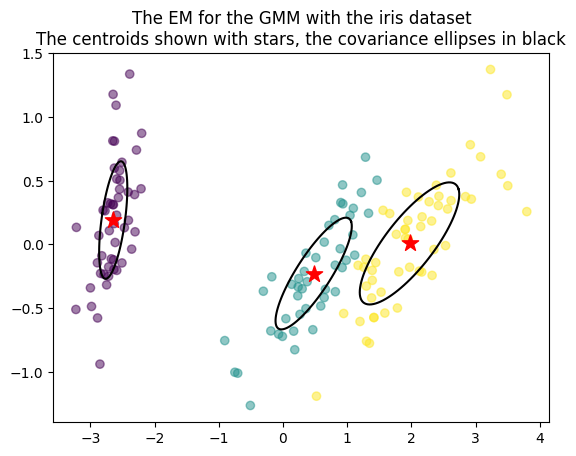

In [7]:
# displaying the transformed 2-d data points along with the centroids (means) and covariance ellipses 
plt.scatter(X2d[:,0],X2d[:,1],c=labels,alpha=.5)
plt.scatter(means[:,0],means[:,1],marker='*',c='red',s=150)
for mean,cov in zip(means,covs):
    points=ellipse_covariance(mean,cov)
    plt.plot(points[0],points[1],c='black')
plt.title('The EM for the GMM with the iris dataset'+\
          '\nThe centroids shown with stars, the covariance ellipses in black')
plt.show()